In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import datetime
import time
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.compose import ColumnTransformer
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.cluster import MiniBatchKMeans
import warnings
warnings.simplefilter("ignore")
%matplotlib inline

sns.set(style="darkgrid")

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"islamkodzokov","key":"88c45c4e73329a4bad1d22289ebde7a7"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c nyc-taxi-trip-duration

test.zip: Skipping, found more recently modified local copy (use --force to force download)
train.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
train = pd.read_csv("train.zip")
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [6]:
train['log_trip_duration'] = np.log1p(train.trip_duration.values)

In [7]:
train

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642
...,...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256


In [8]:
train.drop(columns = ['dropoff_datetime'], inplace=True)

In [10]:
train.pickup_datetime = pd.to_datetime(train.pickup_datetime)

Давайте посмотрим на распределение таргета в обучающей выборке.

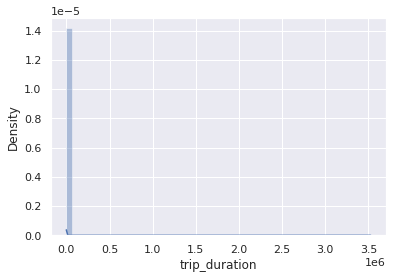

In [11]:
sns.distplot(train['trip_duration'])

 Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

In [12]:
train['log_trip_duration'] = np.log1p(train['trip_duration'])

Гистограмма модифицированного таргета по обучающей выборке.

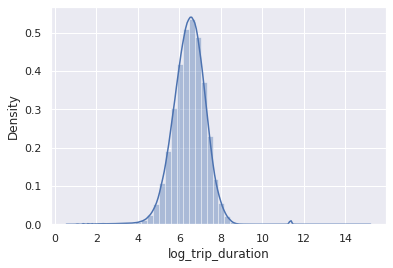

In [13]:
sns.distplot(train['log_trip_duration'])

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [14]:
best_constant = train['log_trip_duration'].mean()

print("Test MSE with best constant = %.4f" % mean_squared_error(train['log_trip_duration'], best_constant * np.ones(train['log_trip_duration'].shape)))

Test MSE with best constant = 0.6332


График зависимости количества поездок от дня в году:

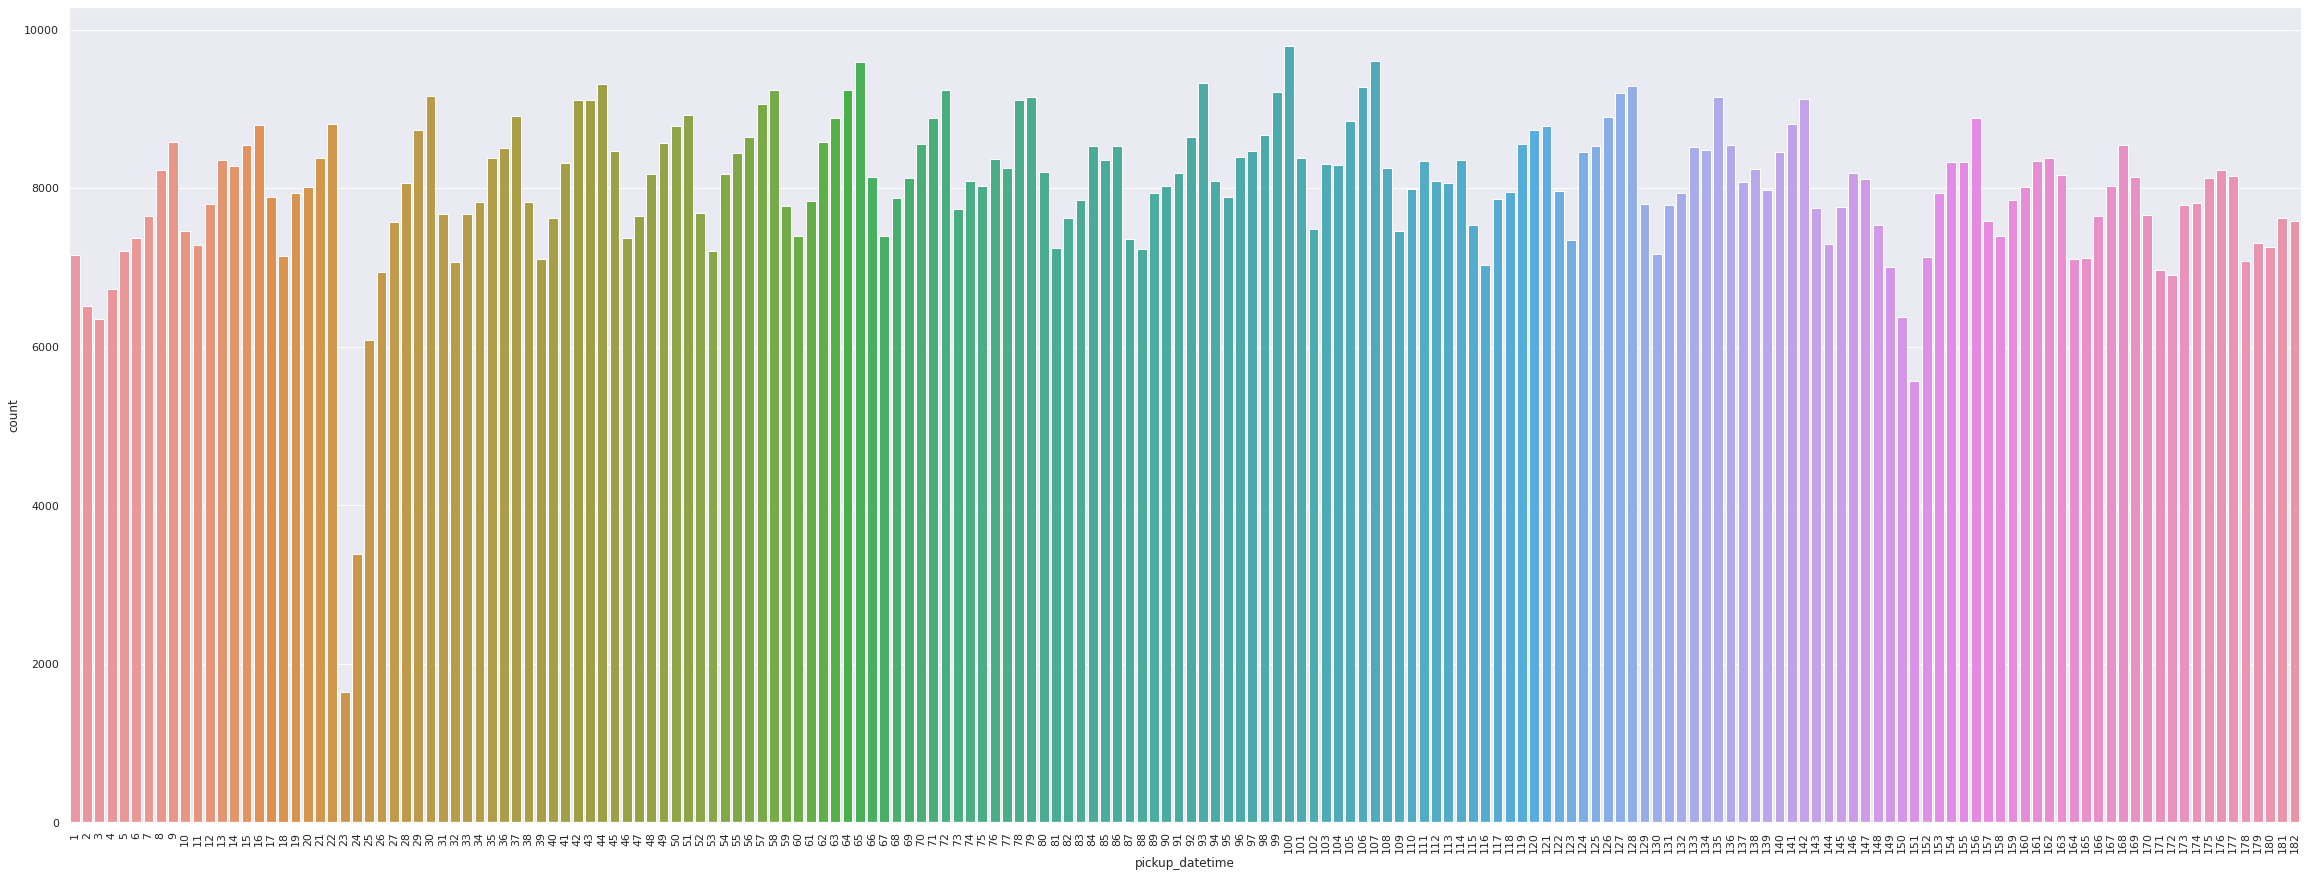

In [15]:
fig, ax = plt.subplots(figsize=(40, 15))
chart = sns.countplot(train['pickup_datetime'].dt.dayofyear)

chart.set_xticklabels(chart.get_xticklabels(), rotation=90)
None

График зависимости количества поездок от дня недели:

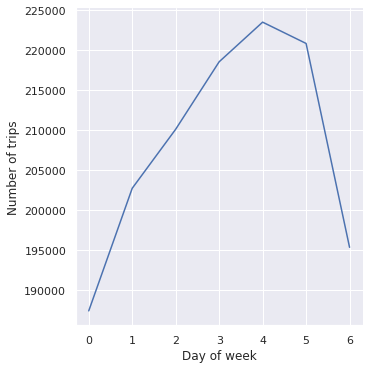

In [16]:
sns.relplot(x=sorted(train.pickup_datetime.dt.dayofweek.unique()), y=train.pickup_datetime.groupby(train['pickup_datetime'].dt.dayofweek).count(), kind='line').set_axis_labels("Day of week", "Number of trips")

графики зависимости количества поездок от часов в сутках:

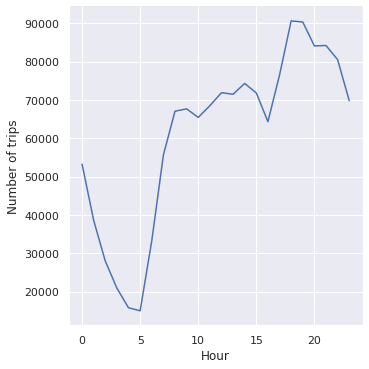

In [17]:
sns.relplot(x=sorted(train.pickup_datetime.dt.hour.unique()), y=train.pickup_datetime.groupby(train['pickup_datetime'].dt.hour).count(), kind='line').set_axis_labels("Hour", "Number of trips")

In [18]:
df_month = pd.DataFrame()
df_month['hour'] = train['pickup_datetime'].dt.hour
df_month['month'] = train['pickup_datetime'].dt.month
df_month['id'] = train['id']

In [19]:
df_month = df_month.groupby(['month', 'hour']).count().reset_index()
df_month.rename(columns={'id':'count'}, inplace=True)
df_month

,month,hour,count
0,1,0,8330
1,1,1,6400
2,1,2,4830
3,1,3,3574
4,1,4,2612
...,...,...,...
139,6,19,14187
140,6,20,12799
141,6,21,13740
142,6,22,13391


In [20]:
df_1 = df_month.pivot('hour', 'month', 'count')
df_1

month,1,2,3,4,5,6
hour,,,,,,
0,8330,8445,8992,9185,9146,9150
1,6400,5981,6441,6741,6632,6376
2,4830,4444,4349,5027,4871,4451
3,3574,3176,3508,3687,3645,3305
4,2612,2418,2734,2602,2856,2570
5,2316,2359,2676,2476,2645,2530
6,5055,5204,5949,5603,5763,5674
7,8600,8826,10026,9606,9471,9071
8,10388,11103,12036,11426,11163,10937


График зависимости количества поездок от часа в сутках для разных месяцев

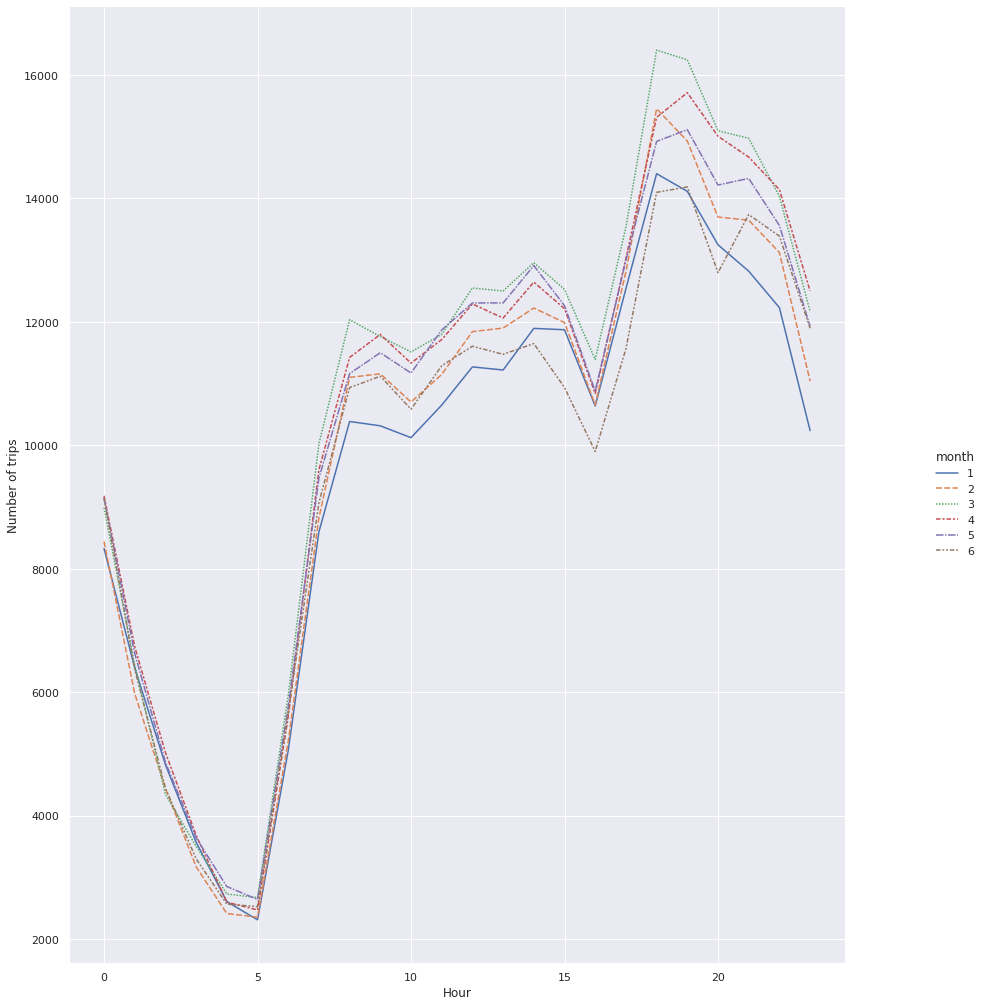

In [21]:
g_1 = sns.relplot(data=df_1, kind='line', ax=ax)
g_1.fig.set_size_inches(15,15)
g_1.set_axis_labels("Hour", "Number of trips")

In [23]:
df_day = pd.DataFrame()
df_day['hour'] = train['pickup_datetime'].dt.hour
df_day['day_of_week'] = train['pickup_datetime'].dt.dayofweek
df_day['id'] = train['id']

In [24]:
df_day = df_day.groupby(['day_of_week', 'hour']).count().reset_index()
df_day.rename(columns={'id':'count'}, inplace=True)
df_day

,day_of_week,hour,count
0,0,0,4299
1,0,1,2578
2,0,2,1658
3,0,3,1226
4,0,4,1351
...,...,...,...
163,6,19,10046
164,6,20,9136
165,6,21,8737
166,6,22,7892


In [25]:
df_2 = df_day.pivot('hour', 'day_of_week', 'count')
df_2 

day_of_week,0,1,2,3,4,5,6
hour,,,,,,,
0,4299,4506,5327,6299,8779,11768,12270
1,2578,2574,3134,3632,5804,9989,10860
2,1658,1508,1890,2145,3949,8240,8582
3,1226,1012,1280,1550,2924,6037,6866
4,1351,1142,1252,1385,2313,3849,4500
5,2147,2126,2087,2222,2461,1997,1962
6,5357,5779,5833,6051,5544,2535,2149
7,8620,10050,10344,10408,9607,3727,2844
8,10342,11608,11889,11936,11465,5480,4333


График зависимости количества поездок от часа в сутках для разных дней недели:

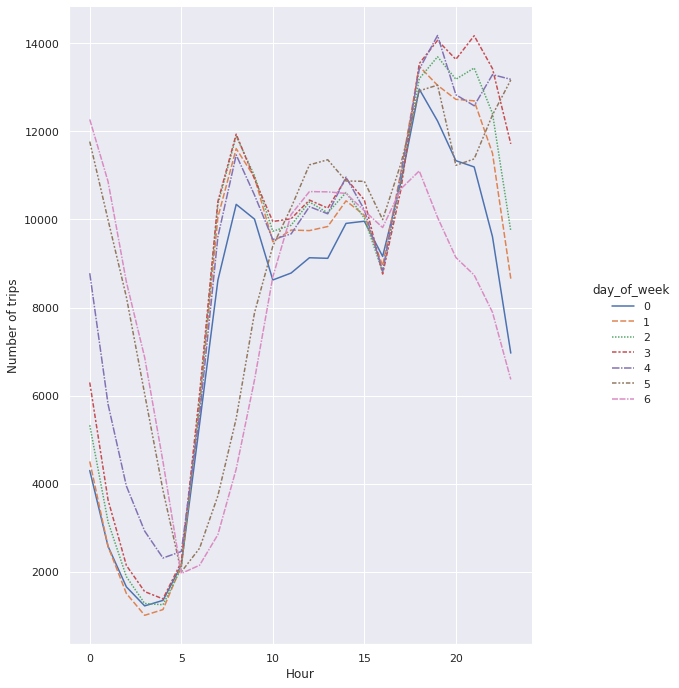

In [26]:
g_2 = sns.relplot(data=df_2, kind='line')
g_2.fig.set_size_inches(10,10)
g_2.set_axis_labels("Hour", "Number of trips")

In [27]:
train

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642
...,...,...,...,...,...,...,...,...,...,...,...
1458639,id2376096,2,2016-04-08 13:31:04,4,-73.982201,40.745522,-73.994911,40.740170,N,778,6.658011
1458640,id1049543,1,2016-01-10 07:35:15,1,-74.000946,40.747379,-73.970184,40.796547,N,655,6.486161
1458641,id2304944,2,2016-04-22 06:57:41,1,-73.959129,40.768799,-74.004433,40.707371,N,764,6.639876
1458642,id2714485,1,2016-01-05 15:56:26,1,-73.982079,40.749062,-73.974632,40.757107,N,373,5.924256


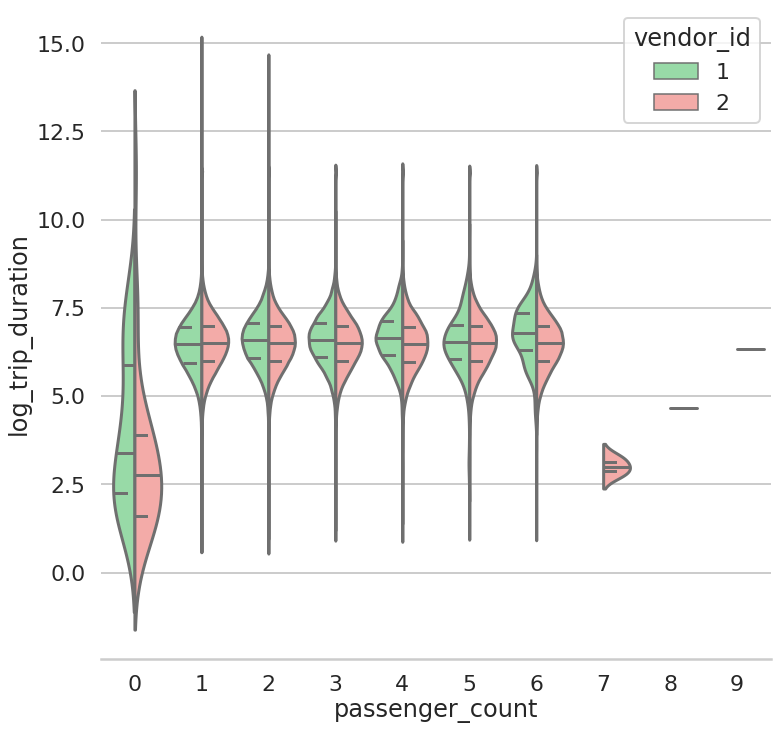

In [28]:
sns.set(style="whitegrid", palette="pastel", color_codes=True)
sns.set_context("poster")
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.violinplot(x="passenger_count", y="log_trip_duration", hue="vendor_id", data=train, split=True,
               inner="quart", palette={1: "g", 2: "r"}, ax = ax)

sns.despine(left=True)

In [29]:
train['day_of_week'] = train['pickup_datetime'].dt.dayofweek
train['month'] = train['pickup_datetime'].dt.month
train['hour'] = train['pickup_datetime'].dt.hour
train['is_anomal_1'] = train['pickup_datetime'].dt.dayofyear == 23
train['is_anomal_2'] = train['pickup_datetime'].dt.dayofyear == 24
train['day_of_year'] = train['pickup_datetime'].dt.dayofyear
train['week_of_year'] = train['pickup_datetime'].dt.weekofyear

3526282
Time taken by above cell is 0.555462121963501.


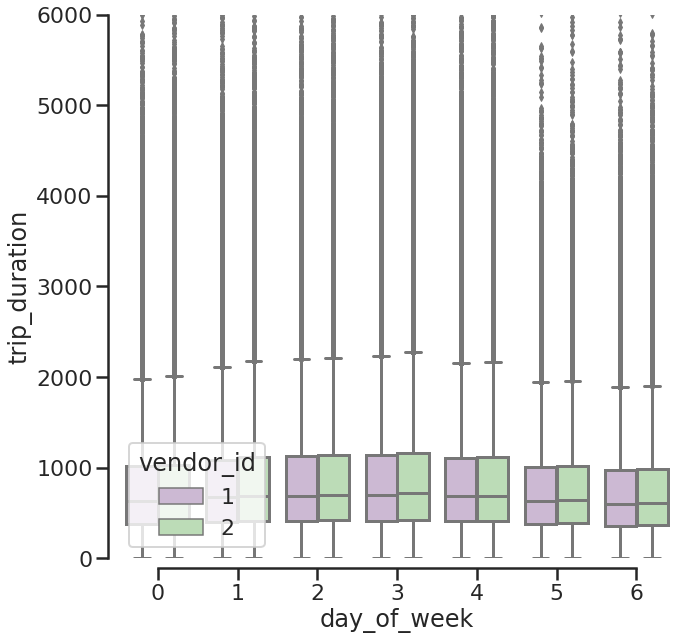

In [33]:
start = time.time()
sns.set(style="ticks")
sns.set_context("poster")
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.boxplot(x="day_of_week", y="trip_duration", hue="vendor_id", data=train, palette="PRGn", ax = ax)
plt.ylim(0, 6000)
sns.despine(offset=10, trim=True)
print(train.trip_duration.max())
end = time.time()
print("Time taken by above cell is {}.".format(end-start))

In [46]:
start = time.time()
def haversine_(lat1, lng1, lat2, lng2):
    """function to calculate haversine distance between two co-ordinates"""
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return(h)

def manhattan_distance_pd(lat1, lng1, lat2, lng2):
    """function to calculate manhatten distance between pick_drop"""
    a = haversine_(lat1, lng1, lat1, lng2)
    b = haversine_(lat1, lng1, lat2, lng1)
    return a + b

import math
def bearing_array(lat1, lng1, lat2, lng2):
    """ function was taken from beluga's notebook as this function works on array
    while my function used to work on individual elements and was noticably slow"""
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

end = time.time()
print("Time taken by above cell is {}.".format((end-start)))

Time taken by above cell is 0.00039267539978027344.


In [47]:
train.loc[:,'hvsine_pick_drop'] = haversine_(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'manhtn_pick_drop'] = manhattan_distance_pd(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:,'bearing'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)

In [42]:
start = time.time()
def assign_cluster(df, k):
    """function to assign clusters """
    df_pick = df[['pickup_longitude','pickup_latitude']]
    df_drop = df[['dropoff_longitude','dropoff_latitude']]
    """I am using initialization as from the output of
    k-means from my local machine to save time in this kernel"""
    init = np.array([[ -73.98737616,   40.72981533],
       [-121.93328857,   37.38933945],
       [ -73.78423222,   40.64711269],
       [ -73.9546417 ,   40.77377538],
       [ -66.84140269,   36.64537175],
       [ -73.87040541,   40.77016484],
       [ -73.97316185,   40.75814346],
       [ -73.98861094,   40.7527791 ],
       [ -72.80966949,   51.88108444],
       [ -76.99779701,   38.47370625],
       [ -73.96975298,   40.69089596],
       [ -74.00816622,   40.71414939],
       [ -66.97216034,   44.37194443],
       [ -61.33552933,   37.85105133],
       [ -73.98001393,   40.7783577 ],
       [ -72.00626526,   43.20296402],
       [ -73.07618713,   35.03469086],
       [ -73.95759366,   40.80316361],
       [ -79.20167796,   41.04752096],
       [ -74.00106031,   40.73867723]])
    k_means_pick = KMeans(n_clusters=k, init=init, n_init=1)
    k_means_pick.fit(df_pick)
    clust_pick = k_means_pick.labels_
    df['label_pick'] = clust_pick.tolist()
    df['label_drop'] = k_means_pick.predict(df_drop)
    return df, k_means_pick

end = time.time()
print("time taken by thie script by now is {}.".format(end-start))

time taken by thie script by now is 0.00021910667419433594.


In [48]:
start = time.time()
train_cl, k_means = assign_cluster(train, 20)  # make it 100 when extracting features 
centroid_pickups = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_pick_long', 'centroid_pick_lat'])
centroid_dropoff = pd.DataFrame(k_means.cluster_centers_, columns = ['centroid_drop_long', 'centroid_drop_lat'])
centroid_pickups['label_pick'] = centroid_pickups.index
centroid_dropoff['label_drop'] = centroid_dropoff.index
#centroid_pickups.head()
train_cl = pd.merge(train_cl, centroid_pickups, how='left', on=['label_pick'])
train_cl = pd.merge(train_cl, centroid_dropoff, how='left', on=['label_drop'])
#train_cl.head()
end = time.time()
print("Time taken in clustering is {}.".format(end - start))

Time taken in clustering is 3.2503464221954346.


In [53]:
start = time.time()
train_cl.loc[:,'hvsine_pick_cent_p'] = haversine_(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'hvsine_drop_cent_d'] = haversine_(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'hvsine_cent_p_cent_d'] = haversine_(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_pick_cent_p'] = manhattan_distance_pd(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'manhtn_drop_cent_d'] = manhattan_distance_pd(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'manhtn_cent_p_cent_d'] = manhattan_distance_pd(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)

train_cl.loc[:,'bearing_pick_cent_p'] = bearing_array(train_cl['pickup_latitude'].values, train_cl['pickup_longitude'].values, train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values)
train_cl.loc[:,'bearing_drop_cent_p'] = bearing_array(train_cl['dropoff_latitude'].values, train_cl['dropoff_longitude'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
train_cl.loc[:,'bearing_cent_p_cent_d'] = bearing_array(train_cl['centroid_pick_lat'].values, train_cl['centroid_pick_long'].values, train_cl['centroid_drop_lat'].values, train_cl['centroid_drop_long'].values)
end = time.time()
print("Time Taken by above cell is {}.".format(end-start))
train_cl.head()

Time Taken by above cell is 2.211190938949585.


,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,log_trip_duration,day_of_week,month,hour,is_anomal_1,is_anomal_2,day_of_year,week_of_year,label_pick,label_drop,hvsine_pick_drop,manhtn_pick_drop,bearing,centroid_pick_long,centroid_pick_lat,centroid_drop_long,centroid_drop_lat,hvsine_pick_cent_p,hvsine_drop_cent_d,hvsine_cent_p_cent_d,manhtn_pick_cent_p,manhtn_drop_cent_d,manhtn_cent_p_cent_d,bearing_pick_cent_p,bearing_drop_cent_p,bearing_cent_p_cent_d
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455,6.122493,0,3,17,False,False,74,11,14,6,1.498521,1.735433,99.970196,-73.980021,40.778359,-73.973191,40.758148,1.172756,1.098585,2.319857,1.338601,1.549840,2.822553,8.812218,-138.980503,165.640915
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6.498282,6,6,0,False,False,164,23,0,19,1.805507,2.430506,-117.153768,-73.987417,40.729722,-74.001071,40.738659,1.146564,0.845448,1.520191,1.573052,0.968702,2.144236,-149.031278,-9.113659,-49.174617
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,7.661527,1,1,11,False,False,19,3,6,11,6.385098,8.203575,-159.680165,-73.973191,40.758148,-74.008230,40.714103,0.810128,0.508922,5.718571,1.135490,0.690697,7.848844,142.642889,-28.669171,-148.907292
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429,6.063785,2,4,19,False,False,97,14,11,11,1.485498,1.661331,-172.737700,-74.008230,40.714103,-74.008230,40.714103,0.670114,0.888828,0.000000,0.805089,1.161466,0.000000,166.837718,22.515049,0.000000
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435,6.077642,5,3,13,False,False,86,12,14,14,1.188588,1.199457,179.473585,-73.980021,40.778359,-73.980021,40.778359,1.752369,0.755820,0.000000,2.237846,1.060322,0.000000,-160.438403,-127.746230,0.000000


In [54]:
y = train['log_trip_duration']
X = train.drop(columns=['log_trip_duration', 'id'])

X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.3, random_state=42)

In [55]:
X_train.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,day_of_week,month,hour,is_anomal_1,is_anomal_2,day_of_year,week_of_year,label_pick,label_drop,hvsine_pick_drop,manhtn_pick_drop,bearing
1011257,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,844,1,5,9,False,False,124,18,6,6,1.263187,1.481502,-11.026369
178550,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,1001,4,1,16,False,False,1,53,6,14,4.804012,5.516762,9.286876
551460,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,1048,6,4,13,False,False,115,16,3,5,7.471088,8.573836,99.217466
1434271,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,784,6,1,17,False,False,10,1,0,6,3.444869,4.039264,11.002169
1173610,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,732,3,2,17,False,False,56,8,6,14,2.481063,3.145986,-18.708343


In [56]:
trip_duration_train = X_train.trip_duration.values
trip_duration_test = X_test.trip_duration.values
X_train.drop(columns=['trip_duration'], inplace=True)
X_test.drop(columns=['trip_duration'], inplace=True)

График зависимости среднего логарифма времени поездки от дня недели

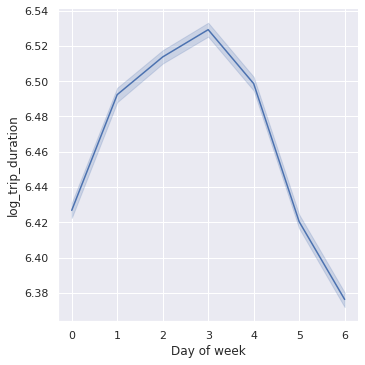

In [57]:
sns.relplot(y=y_train, x=X_train['pickup_datetime'].dt.dayofweek, kind='line').set_axis_labels("Day of week", "log_trip_duration")

График зависимости среднего логарифма времени поездки от часов в сутках

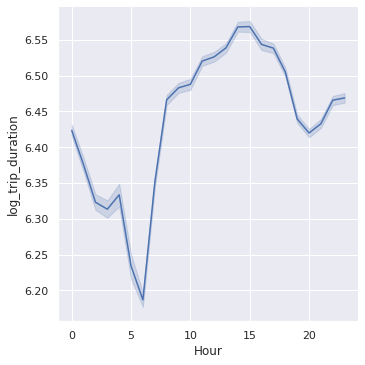

In [58]:
sns.relplot(y=y_train, x=X_train['pickup_datetime'].dt.hour, kind='line').set_axis_labels("Hour", "log_trip_duration")

График зависимости среднего логарифма времени поездки от дня в году

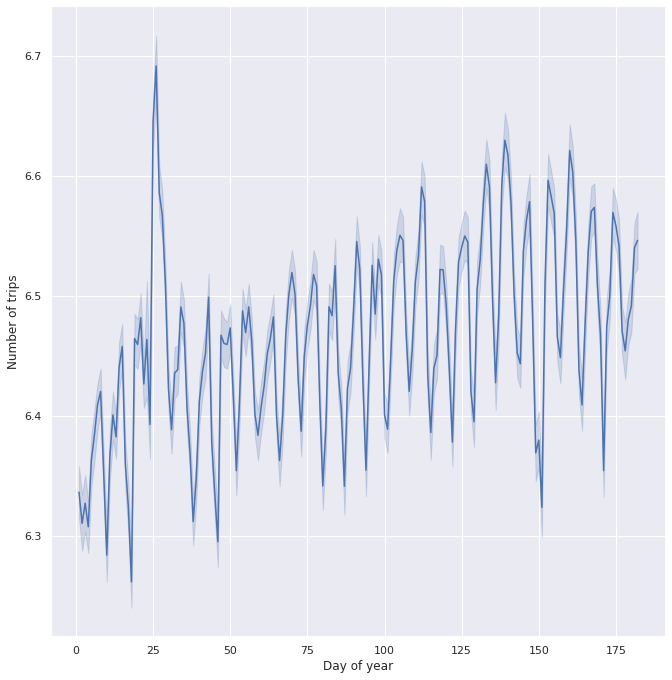

In [59]:
sns.relplot(y=y_train, x=X_train['pickup_datetime'].dt.dayofyear, kind='line').set_axis_labels("Day of year", "Number of trips").fig.set_size_inches(10,10)

In [ ]:
"""
X_train['hour_sin'] = np.sin(X_train['pickup_datetime'].dt.hour * (2.*np.pi/24))
X_train['hour_cos'] = np.cos(X_train['pickup_datetime'].dt.hour * (2.*np.pi/24))
X_train['month_sin'] = np.sin(X_train['pickup_datetime'].dt.month * (2.*np.pi/12))
X_train['month_cos'] = np.cos(X_train['pickup_datetime'].dt.month * (2.*np.pi/12))
X_train['dayofweek_sin'] = np.sin(X_train['pickup_datetime'].dt.dayofweek *(2.*np.pi/7))
X_train['dayofweek_cos'] = np.cos(X_train['pickup_datetime'].dt.dayofweek *(2.*np.pi/7))
X_train['dayofyear_sin'] = np.sin(X_train['pickup_datetime'].dt.dayofyear) * (2.*np.pi/366)
X_train['dayofyear_cos'] = np.cos(X_train['pickup_datetime'].dt.dayofyear) * (2.*np.pi/366)

X_test['hour_sin'] = np.sin(X_test['pickup_datetime'].dt.hour * (2.*np.pi/24))
X_test['hour_cos'] = np.cos(X_test['pickup_datetime'].dt.hour * (2.*np.pi/24))
X_test['month_sin'] = np.sin(X_test['pickup_datetime'].dt.month * (2.*np.pi/12))
X_test['month_cos'] = np.cos(X_test['pickup_datetime'].dt.month * (2.*np.pi/12))
X_test['dayofweek_sin'] = np.sin(X_test['pickup_datetime'].dt.dayofweek *(2.*np.pi/7))
X_test['dayofweek_cos'] = np.cos(X_test['pickup_datetime'].dt.dayofweek *(2.*np.pi/7))
X_test['dayofyear_sin'] = np.sin(X_test['pickup_datetime'].dt.dayofyear) * (2.*np.pi/366)
X_test['dayofyear_cos'] = np.cos(X_test['pickup_datetime'].dt.dayofyear) * (2.*np.pi/366)
"""

In [60]:
X_train.head()

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,month,hour,is_anomal_1,is_anomal_2,day_of_year,week_of_year,label_pick,label_drop,hvsine_pick_drop,manhtn_pick_drop,bearing
1011257,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,False,False,124,18,6,6,1.263187,1.481502,-11.026369
178550,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,False,False,1,53,6,14,4.804012,5.516762,9.286876
551460,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,False,False,115,16,3,5,7.471088,8.573836,99.217466
1434271,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,False,False,10,1,0,6,3.444869,4.039264,11.002169
1173610,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,False,False,56,8,6,14,2.481063,3.145986,-18.708343


In [61]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021050 entries, 1011257 to 121958
Data columns (total 20 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   vendor_id           1021050 non-null  int64         
 1   pickup_datetime     1021050 non-null  datetime64[ns]
 2   passenger_count     1021050 non-null  int64         
 3   pickup_longitude    1021050 non-null  float64       
 4   pickup_latitude     1021050 non-null  float64       
 5   dropoff_longitude   1021050 non-null  float64       
 6   dropoff_latitude    1021050 non-null  float64       
 7   store_and_fwd_flag  1021050 non-null  object        
 8   day_of_week         1021050 non-null  int64         
 9   month               1021050 non-null  int64         
 10  hour                1021050 non-null  int64         
 11  is_anomal_1         1021050 non-null  bool          
 12  is_anomal_2         1021050 non-null  bool          
 13  day_of_

# Изучаем координаты

In [62]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.
    
    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [63]:
show_circles_on_map(X_train.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [64]:
X_train

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,month,hour,is_anomal_1,is_anomal_2,day_of_year,week_of_year,label_pick,label_drop,hvsine_pick_drop,manhtn_pick_drop,bearing
1011257,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,False,False,124,18,6,6,1.263187,1.481502,-11.026369
178550,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,False,False,1,53,6,14,4.804012,5.516762,9.286876
551460,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,False,False,115,16,3,5,7.471088,8.573836,99.217466
1434271,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,False,False,10,1,0,6,3.444869,4.039264,11.002169
1173610,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,False,False,56,8,6,14,2.481063,3.145986,-18.708343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,2,2016-03-25 07:11:49,2,-73.955032,40.777328,-74.006203,40.749424,N,4,3,7,False,False,85,12,3,19,5.310383,7.411524,-125.736618
1414414,1,2016-02-16 18:01:45,1,-73.973618,40.763920,-73.983849,40.749874,N,1,2,18,False,False,47,7,6,7,1.783777,2.423466,-151.108525
131932,2,2016-01-26 19:22:29,1,-74.006195,40.734283,-73.949608,40.785282,N,1,1,19,False,False,26,4,19,3,7.407646,10.438681,40.027128
671155,1,2016-01-19 11:53:47,1,-73.962341,40.767323,-73.969757,40.768669,N,1,1,11,False,False,19,3,3,6,0.642215,0.774256,-76.514866


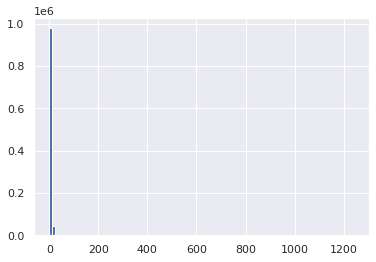

In [72]:
plt.hist(X_train.hvsine_pick_drop, bins=100)
plt.show()

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишем логарифм `haversine` в отдельную колонку:

In [73]:
X_train['log_haversine_distance'] = np.log1p(X_train.hvsine_pick_drop)
X_test['log_haversine_distance'] = np.log1p(X_test.hvsine_pick_drop)

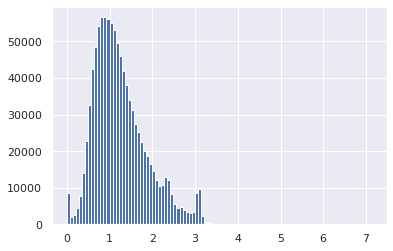

In [74]:
plt.hist(X_train.log_haversine_distance, bins=100)
plt.show()

In [75]:
X_train['speed'] = X_train.hvsine_pick_drop.values / (trip_duration_train / (60 * 60))

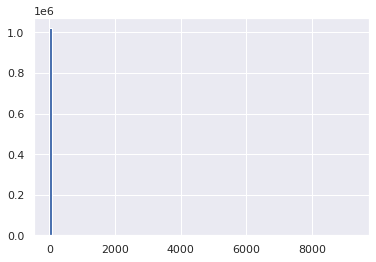

In [76]:
plt.hist(X_train.speed, bins=100)
plt.show()

Как можно видеть по гистограмме, для некоторых объектов получились очень больше значения скоростей. Нарисуем гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать в рассмотрение объекты, где скорость больше некоторой квантили):

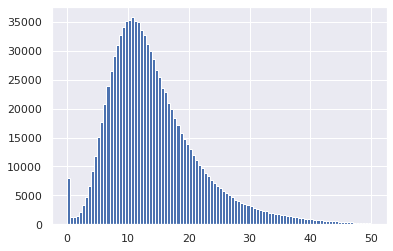

In [77]:
plt.hist(X_train[X_train.speed < 50].speed, bins=100)
plt.show()

In [78]:
df = X_train[['day_of_week', 'hour', 'speed']].groupby(['day_of_week', 'hour']).median().reset_index()
df = df.pivot('hour', 'day_of_week', 'speed')
df

day_of_week,0,1,2,3,4,5,6
hour,,,,,,,
0,20.321886,18.987038,17.862808,17.305269,16.003068,14.138811,14.304210
1,20.138217,19.762714,19.494701,18.929170,17.279698,15.533271,15.322084
2,21.028909,20.296648,20.152371,19.843321,17.989489,16.361695,16.534759
3,20.323811,21.953491,20.941153,21.139309,18.956500,17.518415,17.718611
4,24.216283,22.942440,22.926477,22.487561,20.952063,19.117928,18.729315
5,23.401148,22.933517,22.753551,22.025228,22.975217,22.987934,22.709322
6,18.772996,17.993237,18.326789,18.423010,18.969700,22.198701,23.875976
7,14.515631,13.523563,13.515571,13.595307,13.922863,19.619367,21.179755
8,11.517098,10.436353,10.518892,10.399796,10.828096,17.074518,18.515663


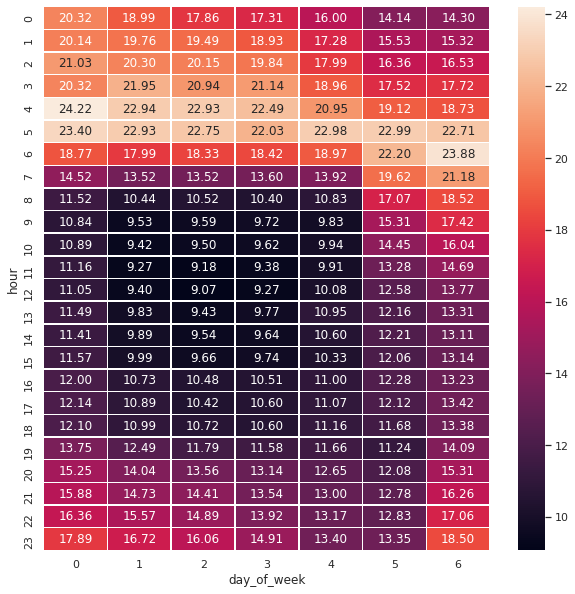

In [79]:
plt.figure(figsize=(10, 10))
sns.heatmap(df, annot=True, fmt='.2f', linewidths=.5)

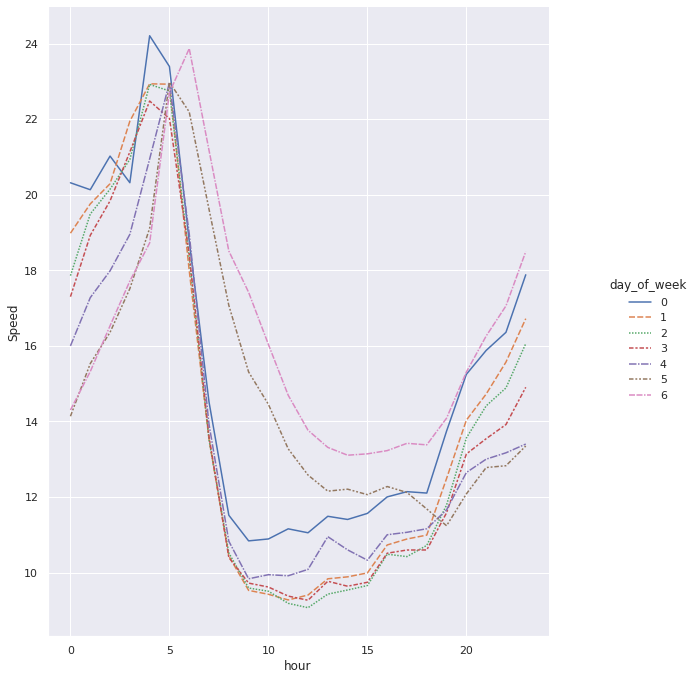

In [80]:
sns.relplot(data = df, kind='line').set_axis_labels('hour', 'Speed').fig.set_size_inches(10,10)

In [81]:
X_train['traffic_period'] = (1 * ((X_train[(X_train.hour >= 8) & (X_train.hour <= 18)].day_of_week <= 4) | 
                                 (X_train[(X_train.hour >= 13) & (X_train.hour <= 18)].day_of_week >= 5))).apply(lambda x: int(x))

X_train['traffic_period'] = X_train['traffic_period'].fillna(0).apply(lambda x: int(x))
X_train['freeway_period'] = X_train['traffic_period'].apply(lambda x: 1 - x)

X_test['traffic_period'] = (1 * ((X_test[(X_test.hour >= 8) & (X_test.hour <= 18)].day_of_week <= 4) | 
                                 (X_test[(X_test.hour >= 13) & (X_test.hour <= 18)].day_of_week >= 5))).apply(lambda x: int(x))

X_test['traffic_period'] = X_test['traffic_period'].fillna(0).apply(lambda x: int(x))
X_test['freeway_period'] = X_test['traffic_period'].apply(lambda x: 1 - x)

In [85]:
start = time.time()
coords = np.vstack((X_train[['pickup_latitude', 'pickup_longitude']].values,
                    X_train[['dropoff_latitude', 'dropoff_longitude']].values,
                    X_test[['pickup_latitude', 'pickup_longitude']].values,
                    X_test[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
X_train['pickup_pca0'] = pca.transform(X_train[['pickup_latitude', 'pickup_longitude']])[:, 0]
X_train['pickup_pca1'] = pca.transform(X_train[['pickup_latitude', 'pickup_longitude']])[:, 1]
X_train['dropoff_pca0'] = pca.transform(X_train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
X_train['dropoff_pca1'] = pca.transform(X_train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
X_test['pickup_pca0'] = pca.transform(X_test[['pickup_latitude', 'pickup_longitude']])[:, 0]
X_test['pickup_pca1'] = pca.transform(X_test[['pickup_latitude', 'pickup_longitude']])[:, 1]
X_test['dropoff_pca0'] = pca.transform(X_test[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
X_test['dropoff_pca1'] = pca.transform(X_test[['dropoff_latitude', 'dropoff_longitude']])[:, 1]
end = time.time()
print("Time Taken by above cell is {}.".format(end - start))

Time Taken by above cell is 0.6492366790771484.


In [86]:
X_train['store_and_fwd_flag_int'] = np.where(X_train['store_and_fwd_flag']=='N', 0, 1)
X_test['store_and_fwd_flag_int'] = np.where(X_test['store_and_fwd_flag']=='N', 0, 1)

In [89]:
feature_names = list(X_train.columns)
print("Difference of features in train and test are {}".format(np.setdiff1d(X_train.columns, X_test.columns)))
print("")
do_not_use_for_training = ['pick_date','id', 'pickup_datetime', 'dropoff_datetime', 'trip_duration', 'store_and_fwd_flag', 'speed']
feature_names = [f for f in train.columns if f not in do_not_use_for_training]
print("We will be using following features for training {}.".format(feature_names))
print("")
print("Total number of features are {}.".format(len(feature_names)))

Difference of features in train and test are ['speed']

We will be using following features for training ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'log_trip_duration', 'day_of_week', 'month', 'hour', 'is_anomal_1', 'is_anomal_2', 'day_of_year', 'week_of_year', 'label_pick', 'label_drop', 'hvsine_pick_drop', 'manhtn_pick_drop', 'bearing'].

Total number of features are 19.


In [97]:
X_train.drop(columns=['speed'], inplace = True)

In [102]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1021050 entries, 1011257 to 121958
Data columns (total 28 columns):
 #   Column                  Non-Null Count    Dtype         
---  ------                  --------------    -----         
 0   vendor_id               1021050 non-null  int64         
 1   pickup_datetime         1021050 non-null  datetime64[ns]
 2   passenger_count         1021050 non-null  int64         
 3   pickup_longitude        1021050 non-null  float64       
 4   pickup_latitude         1021050 non-null  float64       
 5   dropoff_longitude       1021050 non-null  float64       
 6   dropoff_latitude        1021050 non-null  float64       
 7   store_and_fwd_flag      1021050 non-null  object        
 8   day_of_week             1021050 non-null  int64         
 9   month                   1021050 non-null  int64         
 10  hour                    1021050 non-null  int64         
 11  is_anomal_1             1021050 non-null  bool          
 12  is_anomal

In [101]:
X_train

,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,day_of_week,month,hour,is_anomal_1,is_anomal_2,day_of_year,week_of_year,label_pick,label_drop,hvsine_pick_drop,manhtn_pick_drop,bearing,log_haversine_distance,traffic_period,freeway_period,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,store_and_fwd_flag_int
1011257,2,2016-05-03 09:03:08,2,-73.979813,40.752529,-73.982681,40.763680,N,1,5,9,False,False,124,18,6,6,1.263187,1.481502,-11.026369,0.816774,1,0,0.006298,0.001474,0.008627,0.012749,0
178550,1,2016-01-01 16:40:51,1,-73.977623,40.746296,-73.968414,40.788933,N,4,1,16,False,False,1,53,6,14,4.804012,5.516762,9.286876,1.758549,1,0,0.004411,-0.004858,-0.006839,0.037287,0
551460,1,2016-04-24 13:57:03,1,-73.950699,40.779404,-73.863129,40.768608,N,6,4,13,False,False,115,16,3,5,7.471088,8.573836,99.217466,2.136659,1,0,-0.024075,0.026916,-0.111025,0.011920,0
1434271,2,2016-01-10 17:03:47,1,-73.984558,40.721802,-73.976753,40.752213,N,6,1,17,False,False,10,1,0,6,3.444869,4.039264,11.002169,1.491750,1,0,0.012516,-0.028990,0.003257,0.001010,0
1173610,1,2016-02-25 17:37:36,1,-73.967720,40.768742,-73.977173,40.789875,N,3,2,17,False,False,56,8,6,14,2.481063,3.145986,-18.708343,1.247338,1,0,-0.006561,0.017086,0.001864,0.038649,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259178,2,2016-03-25 07:11:49,2,-73.955032,40.777328,-74.006203,40.749424,N,4,3,7,False,False,85,12,3,19,5.310383,7.411524,-125.736618,1.842196,0,1,-0.019647,0.025052,0.032807,-0.000358,0
1414414,1,2016-02-16 18:01:45,1,-73.973618,40.763920,-73.983849,40.749874,N,1,2,18,False,False,47,7,6,7,1.783777,2.423466,-151.108525,1.023809,1,0,-0.000438,0.012553,0.010457,-0.000984,0
131932,2,2016-01-26 19:22:29,1,-74.006195,40.734283,-73.949608,40.785282,N,1,1,19,False,False,26,4,19,3,7.407646,10.438681,40.027128,2.129142,0,1,0.033528,-0.015482,-0.025448,0.032735,0
671155,1,2016-01-19 11:53:47,1,-73.962341,40.767323,-73.969757,40.768669,N,1,1,11,False,False,19,3,3,6,0.642215,0.774256,-76.514866,0.496046,1,0,-0.011865,0.015409,-0.004523,0.017111,0


In [110]:
categorical = list(X_train.dtypes[(X_train.dtypes == 'int64')].index)
numeric = list(X_train.dtypes[X_train.dtypes =="float64"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe and scaling', column_transformer),
    ('regression', Ridge())
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))

Test MSE = 0.2243


In [ ]:
alphas = np.logspace(-2, 3, 20)
searcher = GridSearchCV(pipeline, [{"regression__alpha": alphas}], scoring="neg_mean_squared_error", cv=10)
searcher.fit(X_train, y_train)

best_alpha = searcher.best_params_["regression__alpha"]
print("Best alpha = %.4f" % best_alpha)

plt.plot(alphas, -searcher.cv_results_["mean_test_score"])
plt.xscale("log")
plt.xlabel("alpha")
plt.ylabel("CV score")

In [ ]:
categorical = list(X_train.dtypes[(X_train.dtypes == 'int64')].index)
numeric = list(X_train.dtypes[X_train.dtypes =="float64"].index)

column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown='ignore'), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe and scaling', column_transformer),
    ('regression', Ridge(best_alpha))
])

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test MSE = %.4f" % mean_squared_error(y_test, y_pred))